Initialize

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, min, max, avg, countDistinct, collect_list
import matplotlib.pyplot as plt
import numpy as np

# Create SparkSession
spark = SparkSession.builder \
    .appName("SpotifyAnalysis") \
    .getOrCreate()

# Read Dataset
tracks_df = spark.read.json("hdfs://localhost:9000/datasets/spotify/tracks.json")
playlists_df = spark.read.json("hdfs://localhost:9000/datasets/spotify/playlist.json")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
2025-02-01 08:35:05,894 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
2025-02-01 08:35:06,593 WARN util.Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


Task1

In [2]:
# Task 1: Statistics about songs duration
# 1. Generate a table containing the minimum, average, and maximum duration of songs in milliseconds
duration_stats = tracks_df.agg(min(col("duration_ms")).alias("min_duration"),
                               avg(col("duration_ms")).alias("avg_duration"),
                               max(col("duration_ms")).alias("max_duration"))
duration_stats.show()

# 2. Calculate the first and third quartiles, as well as the interquartile range
Q1 = tracks_df.approxQuantile("duration_ms", [0.25], 0.01)[0]
Q3 = tracks_df.approxQuantile("duration_ms", [0.75], 0.01)[0]
IQR = Q3 - Q1
print(f"Q1: {Q1},Q3: {Q3},IQR:{IQR}")

# 3. Compute the set of songs with durations that are not outliers
non_outliers = tracks_df.filter((col("duration_ms") > Q1 - 1.5 * IQR) & (col("duration_ms") < Q3 + 1.5 * IQR))

# 4. Calculate the number of outliers and generate a new table of statistics for the remaining songs
outliers_count = tracks_df.count() - non_outliers.count()
remaining_stats = non_outliers.agg(min(col("duration_ms")).alias("min_duration"),
                                   avg(col("duration_ms")).alias("avg_duration"),
                                   max(col("duration_ms")).alias("max_duration"))
print(f"Number of outliers: {outliers_count}")
remaining_stats.show()


+------------+------------------+------------+
|min_duration|      avg_duration|max_duration|
+------------+------------------+------------+
|           0|234408.54976216817|    10435467|
+------------+------------------+------------+



Q1: 198026.0,Q3: 258133.0,IQR:60107.0


Number of outliers: 570909


+------------+-----------------+------------+
|min_duration|     avg_duration|max_duration|
+------------+-----------------+------------+
|      107866|226795.8593433425|      348293|
+------------+-----------------+------------+



Task2

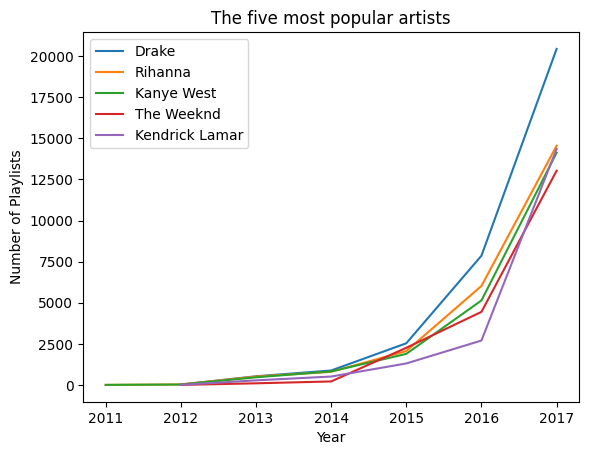

In [3]:
# Task 2: Finding the most popular artists over time
from pyspark.sql.functions import year
# Group by artist and calculate the number of playlists each artist appears in
artist_playlist_count = tracks_df.groupBy("artist_name") \
    .agg(countDistinct("pid").alias("playlist_count")) \
    .orderBy(col("playlist_count").desc()) \
    .limit(5)

# Get the top 5 most popular artists
top_artists = [row.artist_name for row in artist_playlist_count.collect()]

# Convert the last modification time of playlists to years
playlists_df = playlists_df.withColumn("year", year(col("modified_at").cast("timestamp")))

# Join tracks_df and playlists_df
joined_df = tracks_df.join(playlists_df, on="pid")

# Group by artist and year, and calculate the number of playlists each artist appears in per year
yearly_counts = joined_df.filter(col("artist_name").isin(top_artists)) \
    .groupBy("artist_name", "year") \
    .agg(countDistinct("pid").alias("playlist_count")) \
    .orderBy("artist_name", "year")

# Collect the results to the local machine
yearly_counts_collected = yearly_counts.collect()

# Plot the chart
for artist in top_artists:
    artist_data = [row for row in yearly_counts_collected if row.artist_name == artist]
    years = [row.year for row in artist_data]
    counts = [row.playlist_count for row in artist_data]
    plt.plot(years, counts, label=artist)

plt.xlabel('Year')
plt.ylabel('Number of Playlists')
plt.title('The five most popular artists')
plt.legend()
plt.show()

Task3

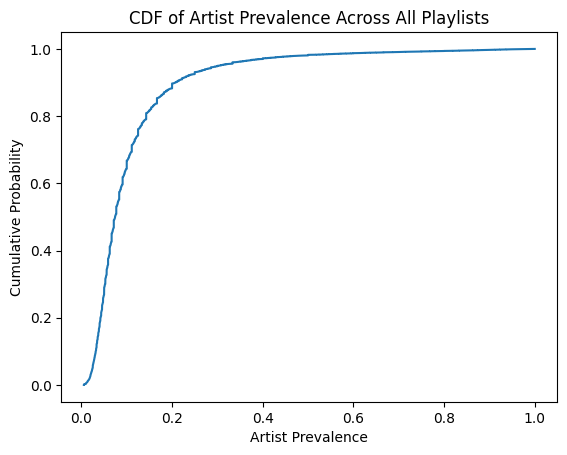

In [4]:
# Task 3: Playlists's behavior
# Group by playlist and artist, and calculate the number of songs by each artist in each playlist
artist_count_per_playlist = tracks_df.groupBy("pid", "artist_name") \
    .agg(countDistinct("track_uri").alias("song_count"))

# Find the artist with the most songs in each playlist
max_artist_per_playlist = artist_count_per_playlist.groupBy("pid") \
    .agg(max(col("song_count")).alias("max_song_count"))

# Join to get the number of songs by the most frequent artist in each playlist
joined_max_artist = artist_count_per_playlist.join(max_artist_per_playlist, on="pid") \
    .filter(col("song_count") == col("max_song_count"))

# Get the total number of songs in each playlist
total_songs_per_playlist = tracks_df.groupBy("pid") \
    .agg(countDistinct("track_uri").alias("total_song_count"))

# Join to calculate the prevalence of the most frequent artist
prevalence_df = joined_max_artist.join(total_songs_per_playlist, on="pid") \
    .withColumn("prevalence", col("max_song_count") / col("total_song_count"))

# Collect the prevalence data
prevalence_data = prevalence_df.select("prevalence").rdd.flatMap(lambda x: x).collect()

# Calculate the cumulative distribution function
sorted_prevalence = np.sort(prevalence_data)
cdf = np.arange(len(sorted_prevalence)) / float(len(sorted_prevalence))

# Plot the CDF graph
plt.figure()
plt.plot(sorted_prevalence, cdf)
plt.xlabel('Artist Prevalence')
plt.ylabel('Cumulative Probability')
plt.title('CDF of Artist Prevalence Across All Playlists')
plt.show()